In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score

from datetime import datetime
import cv2
import os
import zipfile
import shutil
from glob import glob
import glob

from tensorflow.keras.datasets import mnist
import tensorflow.keras.utils as utils


from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator

> https://www.kaggle.com/datasets/paultimothymooney/blood-cells

In [2]:
##### Colab

ROOT_DIR = "/content"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "blood_cell")
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "/content/blood_cell/TRAIN")
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "/content/blood_cell/TEST")
TEST_SIMPLE_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "/content/blood_cell/TEST_SIMPLE")

In [3]:
##### Colab
from google.colab import drive

drive.mount("/content/gdrive/")

shutil.copy(os.path.join("/content/gdrive/MyDrive/acorn", "blood_cell.zip"), ROOT_DIR)

if os.path.exists(DATA_ROOT_DIR):
    shutil.rmtree(DATA_ROOT_DIR)

with zipfile.ZipFile(os.path.join(ROOT_DIR, "blood_cell.zip"), "r") as target_file:
    target_file.extractall(DATA_ROOT_DIR)

Mounted at /content/gdrive/


In [4]:
##### remove blood_cell in blood_cell
source_dir = '/content/blood_cell/blood_cell'
target_dir = '/content/blood_cell'

# Get a list of directories in the source directory
directories = next(os.walk(source_dir))[1]

# Move each directory to the target directory
for directory in directories:
    source_path = os.path.join(source_dir, directory)
    target_path = os.path.join(target_dir, directory)
    shutil.move(source_path, target_path)

directory_to_remove = '/content/blood_cell/blood_cell'

# Remove the directory and its contents
shutil.rmtree(directory_to_remove)

In [5]:

train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print("test label :", label_name, " => ", len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))


test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

for label_name in test_label_name_list:
    print("test label :", label_name, " => ", len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))))


test_simple_label_name_list = os.listdir(TEST_SIMPLE_DATA_ROOT_DIR)
print(test_simple_label_name_list)

for label_name in test_simple_label_name_list:
    print("val label :", label_name, " => ", len(os.listdir(os.path.join(TEST_SIMPLE_DATA_ROOT_DIR, label_name))))

['NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE']
test label : NEUTROPHIL  =>  2499
test label : MONOCYTE  =>  2478
test label : EOSINOPHIL  =>  2497
test label : LYMPHOCYTE  =>  2483
['NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE']
test label : NEUTROPHIL  =>  624
test label : MONOCYTE  =>  620
test label : EOSINOPHIL  =>  623
test label : LYMPHOCYTE  =>  620
['NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE']
val label : NEUTROPHIL  =>  48
val label : MONOCYTE  =>  4
val label : EOSINOPHIL  =>  13
val label : LYMPHOCYTE  =>  6


In [6]:
##### Let's shuffle

test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

['NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE']


In [7]:
##### Move to TRAIN at all files in TEST
for label_name in test_label_name_list:
    test_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)
    test_file_list = os.listdir(test_path)

    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)

    move_num = 0

    for test_file in test_file_list:
        shutil.move(os.path.join(test_path, test_file),
                   os.path.join(train_path, test_file))
        move_num = move_num + 1

    print(str(move_num) + " is moved into " + label_name + \
         "(TEST => Train)")

624 is moved into NEUTROPHIL(TEST => Train)
620 is moved into MONOCYTE(TEST => Train)
623 is moved into EOSINOPHIL(TEST => Train)
620 is moved into LYMPHOCYTE(TEST => Train)


In [8]:
##### Move to TRAIN all files in TEST_SIMPLE
for label_name in test_simple_label_name_list:
    test_simple_path = os.path.join(TEST_SIMPLE_DATA_ROOT_DIR, label_name)
    test_simple_file_list = os.listdir(test_simple_path)

    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)

    move_num = 0

    for test_simple_file in test_simple_file_list:
        shutil.move(os.path.join(test_simple_path, test_simple_file),
                   os.path.join(train_path, test_simple_file))
        move_num = move_num + 1

    print(str(move_num) + " is moved into " + label_name + \
         "(TEST_SIMPLE => Train)")

48 is moved into NEUTROPHIL(TEST_SIMPLE => Train)
4 is moved into MONOCYTE(TEST_SIMPLE => Train)
13 is moved into EOSINOPHIL(TEST_SIMPLE => Train)
6 is moved into LYMPHOCYTE(TEST_SIMPLE => Train)


In [9]:

train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print("test label :", label_name, " => ", len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

['NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE']
test label : NEUTROPHIL  =>  3171
test label : MONOCYTE  =>  3095
test label : EOSINOPHIL  =>  3133
test label : LYMPHOCYTE  =>  3108


In [10]:

MOVE_RATIO = 0.2

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

for label_name in label_name_list:
    src = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    dst = os.path.join(TEST_DATA_ROOT_DIR, label_name)

    train_data_file_list = os.listdir(src)

    print("============================================")
    print("total [%s] data file nums => [%s]"%(label_name, len(train_data_file_list)))

    np.random.shuffle(train_data_file_list)
    print("train data shuffle is done!")

    split_num = int(MOVE_RATIO * len(train_data_file_list))
    print("split num => ", split_num)

    test_data_file_list = train_data_file_list[0:split_num]

    move_num = 0
    for test_data_file in test_data_file_list:
        shutil.move(os.path.join(src, test_data_file),
                   os.path.join(dst, test_data_file))
        move_num = move_num + 1

    print("total move num => ", move_num)
    print("=============================================")

total [NEUTROPHIL] data file nums => [3171]
train data shuffle is done!
split num =>  634
total move num =>  634
total [MONOCYTE] data file nums => [3095]
train data shuffle is done!
split num =>  619
total move num =>  619
total [EOSINOPHIL] data file nums => [3133]
train data shuffle is done!
split num =>  626
total move num =>  626
total [LYMPHOCYTE] data file nums => [3108]
train data shuffle is done!
split num =>  621
total move num =>  621


In [11]:

train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print("test label :", label_name, " => ", len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

for label_name in test_label_name_list:
    print("test label :", label_name, " => ", len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))))

['NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE']
test label : NEUTROPHIL  =>  2537
test label : MONOCYTE  =>  2476
test label : EOSINOPHIL  =>  2507
test label : LYMPHOCYTE  =>  2487
['NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE']
test label : NEUTROPHIL  =>  634
test label : MONOCYTE  =>  619
test label : EOSINOPHIL  =>  626
test label : LYMPHOCYTE  =>  621


Found 8007 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Found 2500 images belonging to 4 classes.
Found 0 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}
4
(16, 224, 224, 3) (16,)
[2. 3. 0. 3. 0. 3. 1. 1. 2. 2. 2. 3. 3. 0. 2. 1.]
17225924/17225924 [==============================] - 2s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv

251/251 [==============================] - 61s 141ms/step - loss: 1.6502 - acc: 0.2579 - val_loss: 1.3406 - val_acc: 0.3620
Epoch 2/20
251/251 [==============================] - ETA: 0s - loss: 1.4371 - acc: 0.2879
Epoch 2: val_loss improved from 1.34065 to 1.29334, saving model to content/


251/251 [==============================] - 33s 133ms/step - loss: 1.4371 - acc: 0.2879 - val_loss: 1.2933 - val_acc: 0.4845
Epoch 3/20
251/251 [==============================] - ETA: 0s - loss: 1.3513 - acc: 0.3457
Epoch 3: val_loss improved from 1.29334 to 1.23367, saving model to content/


251/251 [==============================] - 34s 136ms/step - loss: 1.3513 - acc: 0.3457 - val_loss: 1.2337 - val_acc: 0.5920
Epoch 4/20
251/251 [==============================] - ETA: 0s - loss: 1.2680 - acc: 0.3965
Epoch 4: val_loss improved from 1.23367 to 1.09131, saving model to content/


251/251 [==============================] - 34s 137ms/step - loss: 1.2680 - acc: 0.3965 - val_loss: 1.0913 - val_acc: 0.6925
Epoch 5/20
251/251 [==============================] - ETA: 0s - loss: 1.1470 - acc: 0.4791
Epoch 5: val_loss improved from 1.09131 to 0.87786, saving model to content/


251/251 [==============================] - 34s 135ms/step - loss: 1.1470 - acc: 0.4791 - val_loss: 0.8779 - val_acc: 0.7865
Epoch 6/20
251/251 [==============================] - ETA: 0s - loss: 0.9650 - acc: 0.5870
Epoch 6: val_loss improved from 0.87786 to 0.60665, saving model to content/


251/251 [==============================] - 34s 136ms/step - loss: 0.9650 - acc: 0.5870 - val_loss: 0.6066 - val_acc: 0.8480
Epoch 7/20
251/251 [==============================] - ETA: 0s - loss: 0.7731 - acc: 0.6857
Epoch 7: val_loss improved from 0.60665 to 0.39813, saving model to content/


251/251 [==============================] - 34s 136ms/step - loss: 0.7731 - acc: 0.6857 - val_loss: 0.3981 - val_acc: 0.8995
Epoch 8/20
251/251 [==============================] - ETA: 0s - loss: 0.5986 - acc: 0.7672
Epoch 8: val_loss improved from 0.39813 to 0.25365, saving model to content/


251/251 [==============================] - 34s 136ms/step - loss: 0.5986 - acc: 0.7672 - val_loss: 0.2536 - val_acc: 0.9295
Epoch 9/20
251/251 [==============================] - ETA: 0s - loss: 0.4736 - acc: 0.8195
Epoch 9: val_loss improved from 0.25365 to 0.18308, saving model to content/


251/251 [==============================] - 34s 135ms/step - loss: 0.4736 - acc: 0.8195 - val_loss: 0.1831 - val_acc: 0.9430
Epoch 10/20
251/251 [==============================] - ETA: 0s - loss: 0.3624 - acc: 0.8647
Epoch 10: val_loss improved from 0.18308 to 0.13744, saving model to content/


251/251 [==============================] - 34s 137ms/step - loss: 0.3624 - acc: 0.8647 - val_loss: 0.1374 - val_acc: 0.9505
Epoch 11/20
251/251 [==============================] - ETA: 0s - loss: 0.2947 - acc: 0.8931
Epoch 11: val_loss improved from 0.13744 to 0.11232, saving model to content/


251/251 [==============================] - 34s 134ms/step - loss: 0.2947 - acc: 0.8931 - val_loss: 0.1123 - val_acc: 0.9605
Epoch 12/20
251/251 [==============================] - ETA: 0s - loss: 0.2288 - acc: 0.9207
Epoch 12: val_loss improved from 0.11232 to 0.08372, saving model to content/


251/251 [==============================] - 34s 137ms/step - loss: 0.2288 - acc: 0.9207 - val_loss: 0.0837 - val_acc: 0.9705
Epoch 13/20
251/251 [==============================] - ETA: 0s - loss: 0.1759 - acc: 0.9391
Epoch 13: val_loss improved from 0.08372 to 0.06414, saving model to content/


251/251 [==============================] - 34s 136ms/step - loss: 0.1759 - acc: 0.9391 - val_loss: 0.0641 - val_acc: 0.9740
Epoch 14/20
251/251 [==============================] - ETA: 0s - loss: 0.1510 - acc: 0.9502
Epoch 14: val_loss improved from 0.06414 to 0.04910, saving model to content/


251/251 [==============================] - 34s 136ms/step - loss: 0.1510 - acc: 0.9502 - val_loss: 0.0491 - val_acc: 0.9800
Epoch 15/20
251/251 [==============================] - ETA: 0s - loss: 0.1160 - acc: 0.9624
Epoch 15: val_loss improved from 0.04910 to 0.03982, saving model to content/


251/251 [==============================] - 34s 135ms/step - loss: 0.1160 - acc: 0.9624 - val_loss: 0.0398 - val_acc: 0.9865
Epoch 16/20
251/251 [==============================] - ETA: 0s - loss: 0.0966 - acc: 0.9690
Epoch 16: val_loss improved from 0.03982 to 0.03975, saving model to content/


251/251 [==============================] - 34s 135ms/step - loss: 0.0966 - acc: 0.9690 - val_loss: 0.0397 - val_acc: 0.9865
Epoch 17/20
251/251 [==============================] - ETA: 0s - loss: 0.0753 - acc: 0.9780
Epoch 17: val_loss improved from 0.03975 to 0.02934, saving model to content/


251/251 [==============================] - 34s 137ms/step - loss: 0.0753 - acc: 0.9780 - val_loss: 0.0293 - val_acc: 0.9900
Epoch 18/20
251/251 [==============================] - ETA: 0s - loss: 0.0666 - acc: 0.9786
Epoch 18: val_loss improved from 0.02934 to 0.02837, saving model to content/


251/251 [==============================] - 34s 134ms/step - loss: 0.0666 - acc: 0.9786 - val_loss: 0.0284 - val_acc: 0.9885
Epoch 19/20
251/251 [==============================] - ETA: 0s - loss: 0.0535 - acc: 0.9848
Epoch 19: val_loss improved from 0.02837 to 0.02619, saving model to content/


251/251 [==============================] - 34s 137ms/step - loss: 0.0535 - acc: 0.9848 - val_loss: 0.0262 - val_acc: 0.9900
Epoch 20/20
251/251 [==============================] - ETA: 0s - loss: 0.0465 - acc: 0.9864
Epoch 20: val_loss improved from 0.02619 to 0.02118, saving model to content/


251/251 [==============================] - 34s 137ms/step - loss: 0.0465 - acc: 0.9864 - val_loss: 0.0212 - val_acc: 0.9925
Elapsed Time :  0:11:48.398321


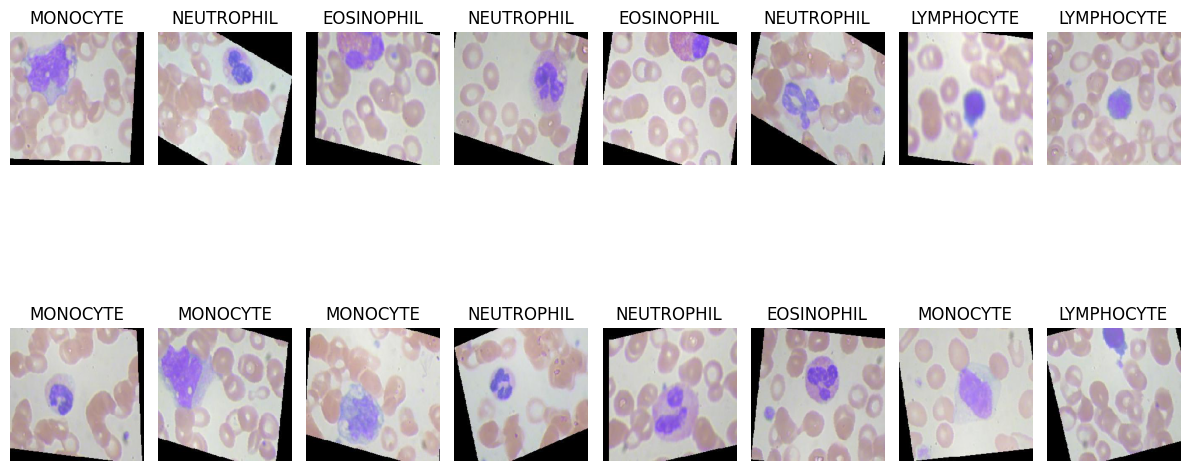

In [12]:
IMG_WIDTH = 224
IMG_HEIGHT = 224


train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)
test_simple_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, batch_size=32, color_mode='rgb'
                        ,target_size=(IMG_WIDTH, IMG_HEIGHT),
                       class_mode = "sparse", subset="training")

val_generator = validation_datagen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, batch_size=32, color_mode='rgb'
                        ,target_size=(IMG_WIDTH, IMG_HEIGHT),
                       class_mode = "sparse", subset="validation")

test_generator = test_datagen.flow_from_directory(directory=TEST_DATA_ROOT_DIR, batch_size=32, color_mode='rgb'
                        ,target_size=(IMG_WIDTH, IMG_HEIGHT),
                       class_mode = "sparse")
test_simple_generator = test_datagen.flow_from_directory(directory=TEST_SIMPLE_DATA_ROOT_DIR, batch_size=32, color_mode='rgb'
                        ,target_size=(IMG_WIDTH, IMG_HEIGHT),
                       class_mode = "sparse")

print(train_generator.class_indices)
print(train_generator.num_classes)

data, label = train_generator.next()

data = data[:16]
label = label[:16]

print(data.shape, label.shape)
print(label)

plt.figure(figsize=(12, 12))
class_dict = {0 : 'EOSINOPHIL', 1 : 'LYMPHOCYTE', 2 : 'MONOCYTE', 3 : 'NEUTROPHIL'}


for i in range(len(label)):
    plt.subplot(4, 8, i+1)
    plt.axis("off")
    plt.title(class_dict[label[i]])
    plt.imshow(data[i])

plt.tight_layout()

pre_trained_model = MobileNet(weights="imagenet", include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

pre_trained_model.summary()

model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(train_generator.num_classes, activation="softmax"))

model.summary()

model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(2e-5), metrics=["acc"]) # 2e-5

start_time = datetime.now()

save_file_name = 'content/'

checkpoint = ModelCheckpoint(save_file_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

earlystopping = EarlyStopping(monitor = 'val_loss', patience=5)

result = model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=[checkpoint, earlystopping])

end_time = datetime.now()
print("Elapsed Time : ", end_time - start_time)

63/63 [==============================] - 4s 64ms/step - loss: 0.0212 - acc: 0.9925


[0.021178629249334335, 0.9925000071525574]

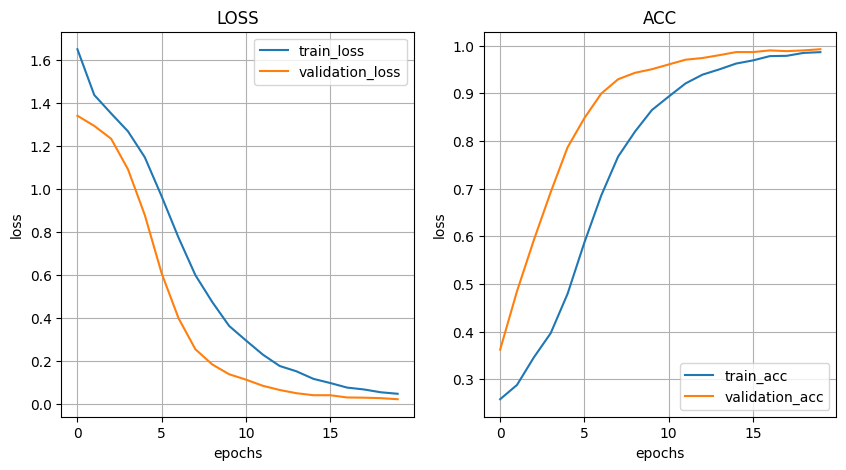

In [13]:
# include_top = False
# ResNet
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")

plt.subplot(1,2,2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["acc"], label="train_acc")
plt.plot(result.history["val_acc"], label="validation_acc")
plt.legend(loc="best")

model.evaluate(val_generator)